In [1]:
import os
import requests

file_path = "lotr1.txt"

with open(file_path, "r", encoding="latin-1") as f:
    text = f.read()

print(text[:270])

Three Rings for the Elven-kings under the sky,
               Seven for the Dwarf-lords in their halls of stone,
            Nine for Mortal Men doomed to die,
              One for the Dark Lord on his dark throne
           In the Land of Mordor where the Shadows lie.


In [2]:
from collections import Counter

words = text.split()
print(len(words))

word_counts = Counter(words)
vocab = [word for word, freq in word_counts.most_common()]

stoi = {s: i+1 for i, s in enumerate(vocab)}
stoi[" "] = 0
itos = {i: s for s, i in stoi.items()}

187838


In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def build_dataset(corpus):
    n = 3
    X, Y = [], []
    context = [0] * n
    
    for word in corpus:
    
        ix = stoi[word]
        X.append(context)
        Y.append(ix)
        # print(''.join([itos[i] for i in context]), "->", itos[ix])
        context = context[1:] + [ix]

    X, Y = torch.tensor(X), torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [4]:
len(Xtr), len(Xdev), len(Xte)

(150270, 18784, 18784)

In [5]:
m = 30
C = torch.randn(len(stoi), m)
C.shape

torch.Size([20196, 30])

In [6]:
emb = C[Xtr]
print(emb.shape)
emb[0][0]

torch.Size([150270, 3, 30])


tensor([-2.5360e-01,  1.5989e+00, -9.4761e-01, -9.9710e-01, -6.0821e-02,
         3.5006e-01,  1.3072e+00,  1.8056e-03,  3.2653e-01,  1.1783e-01,
         1.5069e+00, -1.0007e+00, -5.3403e-01, -1.2088e+00,  3.5224e-01,
        -2.6557e-01, -6.5325e-01,  2.6452e-01,  6.1630e-01, -6.1142e-01,
         4.8930e-01,  7.6214e-01,  1.2580e+00, -8.0761e-01,  2.9663e-01,
        -2.0261e+00,  2.0530e-01,  4.4115e-01,  7.5365e-01, -8.2136e-01])

In [7]:
emb_c = emb.view(Ytr.size(0), -1)
emb_c.size()

torch.Size([150270, 90])

In [8]:
C = torch.randn(len(stoi), m)
W1 = torch.randn(90, 50) * 0.01
b1 = torch.zeros(50)
W2 = torch.randn(50, len(stoi)) * 0.01
b2 = torch.zeros(len(stoi))

In [9]:
parameters  = [C, W1, b1, W2, b2]
steps = []
losses = []

for p in parameters:
  p.requires_grad = True

sum(p.nelement() for p in parameters)

1640426

In [10]:
def inverse_root_decay(i, lr0=0.1, t0=10000):
    lr = lr0 / ((1 + (i / t0)) ** 0.5)
    return lr

In [12]:
num_iter = 100000
for i in range(num_iter):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (64,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(emb.size(0), -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = inverse_root_decay(i, 0.1, 10000)
    for p in parameters:
        p.data += -lr * p.grad

    steps.append(i)
    losses.append(loss.log10().item())

tensor(6.9793, grad_fn=<NllLossBackward0>)


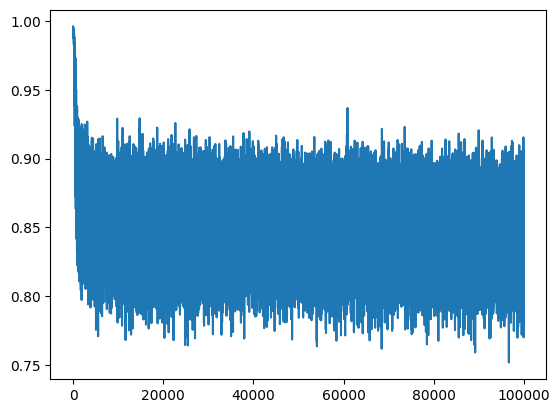

In [13]:
plt.plot(steps, losses)
print(loss)

In [ ]:
def calculate_loss(X, Y):
    emb = C[X]
    h = torch.tanh(emb.view(emb.size(0), -1) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)

    return loss

calculate_loss(Xtr, Ytr)

In [130]:
g = torch.Generator().manual_seed(2147483647 + 12)
out = []

block_size = 3
context = [0] * block_size
for _ in range(100):
    
    emb = C[torch.tensor([context])] # (1,block_size,d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    
    out.append(ix)
    context = context[1:] + [ix]

print(' '.join([itos[i] for i in out]))

after as not standards. scribes abstracts. now, with the North-West of this race on on to other all the an long-lived and inn memory they today; Dwarves, forty with their from This it was existence, largely think a ants as they who to frozen variety Bumpkin, Elf-magic came and need with they was first room, to find the Elves, himself, had on Gandalf with was that I theme purposes.' fortunate to Underhill much enjoyed they were, already yet with orcs, and the most of the Land numerous, put been 1939, it by in the Long peace He The Lord and
